In [31]:
#import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from io import StringIO
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import re
import nltk

%matplotlib inline


In [2]:
# normalize function

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I)
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    doc = ''.join(i for i in doc if not i.isdigit())
    return doc

normalize_corpus = np.vectorize(normalize_document)

#load in corpus
df = pd.read_csv('data/subset.csv')

col = ['stars_y', 'text']
df = df[col]
df = df[pd.notnull(df['text'])]

df.columns = ['stars_y', 'text']

norm_df = normalize_corpus(df['text'])

In [16]:
features = df.text

In [34]:
# binarize reviews
df['stars'] = (df['stars_y'] > 3).astype(int)

labels = df.stars

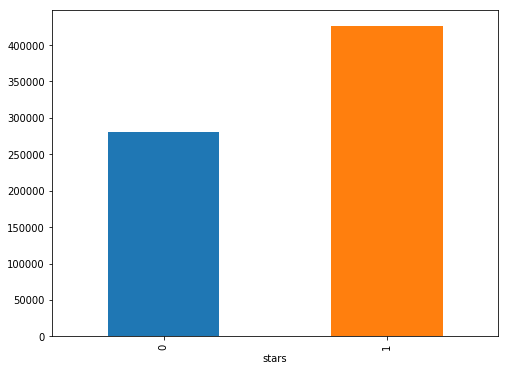

In [37]:
#distribution of reviews
fig = plt.figure(figsize=(8,6))
df.groupby('stars').text.count().plot.bar(ylim=0)
plt.show()

In [27]:

from keras.preprocessing.text import Tokenizer

# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('data/wiki-news-300d-1M.vec', encoding="utf8")):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = Tokenizer()
token.fit_on_texts(features)
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
features = pad_sequences(token.texts_to_sequences(features), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [35]:
# build train and test datasets

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

In [45]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid).argmax(-1)

    return predictions

In [36]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
predictions = train_model(classifier, X_train, y_train, X_test)

accuracy = accuracy_score(y_test, predictions)
F1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print("CNN, Word Embeddings")
print ("Accuracy: ", accuracy)
print ("F1: ", F1)
print ("Precision: ", precision)
print ("Recall: ", recall)

Epoch 1/1
473509/473509 [==============================] - 846s 2ms/step - loss: 0.3656
CNN, Word Embeddings
Accuracy:  0.39591462211969713
F1:  0.0
Precision:  0.0
Recall:  0.0


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
def create_rnn_lstm():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_lstm()
predictions = train_model(classifier, X_train, y_train, X_test)

accuracy = accuracy_score(y_test, predictions)
F1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print("RNN-LSTM, Word Embeddings")
print ("Accuracy: ", accuracy)
print ("F1: ", F1)
print ("Precision: ", precision)
print ("Recall: ", recall)

Epoch 1/1
473509/473509 [==============================] - 1919s 4ms/step - loss: 0.3797
RNN-LSTM, Word Embeddings
Accuracy:  0.39591462211969713
F1:  0.0
Precision:  0.0
Recall:  0.0


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
def create_rcnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    # Add the recurrent layer
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rcnn()
rcnn_predictions = train_model(classifier, X_train, y_train, X_test, is_neural_net=True)

accuracy = accuracy_score(y_test, rcnn_predictions)
#F1 = f1_score(y_test, predictions)
#precision = precision_score(y_test, predictions)
#recall = recall_score(y_test, predictions)

print("CNN, Word Embeddings")
print ("Accuracy: ", accuracy)
#print ("F1: ", F1)
#print ("Precision: ", precision)
#print ("Recall: ", recall)

Epoch 1/1
473509/473509 [==============================] - 823s 2ms/step - loss: 0.3675
CNN, Word Embeddings
Accuracy:  0.39591462211969713


In [53]:
rcnn_predictions[1:70]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

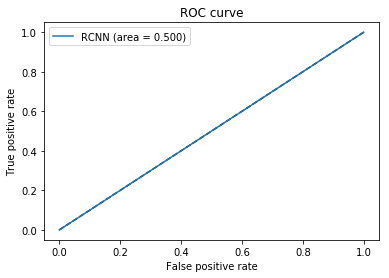

In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr_rcnn, tpr_rcnn, thresholds_rcnn = roc_curve(y_test, rcnn_predictions)
auc_rcnn = auc(fpr_rcnn, tpr_rcnn)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rcnn, tpr_rcnn, label='RCNN (area = {:.3f})'.format(auc_rcnn))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()